In [168]:
'''MPC WITH A SIMPLIFIED STATE SPACE MODEL FOR DEBUGGING / LEARNING PURPOSES'''
# import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sp
from sympy.utilities.lambdify import lambdify
from matplotlib import rcParams
import casadi as ca
import do_mpc

In [169]:
# Build state space model
# making it 3DOF with translation motion.

# Define symbolic variables
# z, z_dot, z_dd = sp.symbols('z z_dot z_dd')
# # z - altitude, z_dot - vertical velocity, z_dd - vertical acceleration
# T = sp.symbols('T')  # thrust

# define numeric variables (adjust as needed)
g = 9.81  # gravity
m = 1.0  # mass, constant for now.
rho = 1.225  # air density
A = 0.1  # cross-sectional area
C_d = 0.5  # drag coefficient
# A and cD assumed to be constant for simplicity

# define equations of motion
# x_d = f(x,u), where f is some nonlinear function. 
# state is defined as z, the altitude and z_dot, the vertical velocity
model = do_mpc.model.Model('continuous')

x = model.set_variable('_x', 'x', shape=(6,1))
T = model.set_variable('_u', 'T')
a = model.set_variable('_u', 'a')
b = model.set_variable('_u', 'b')

rhs = ca.vertcat(
    x[1],                                                            # ẋ = v_x
    (1/m)*(T*ca.cos(b)*ca.sin(a) - 0.5*rho*A*C_d*(ca.fabs(x[1]))*x[1]),
    x[3],                                                            # ẏ = v_y
    (1/m)*(T*ca.sin(a)           - 0.5*rho*A*C_d*(ca.fabs(x[3]))*x[3]),
    x[5],                                                            # ż = v_z
    (1/m)*(T*ca.cos(b)*ca.cos(a) - m*g - 0.5*rho*A*C_d*(ca.fabs(x[5]))*x[5])
)

model.set_rhs('x', rhs)            # one call, matching the vector state

model.setup()

In [170]:
# Configuring controller
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    # automatically discretized with collocation
    'n_horizon': 10,
    't_step': 0.1,
    'n_robust': 1, # default to 0 if not specified
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [171]:
# Cost Function. Will be defined as a quadratic function
# error between desired and actual state as well as control effort.
x_ref = 10.0  # desired x position
x_dot_ref = 0.0  # desired x velocity
y_ref = 10.0  # desired y position
y_dot_ref = 0.0  # desired y velocity
z_ref = 5.0  # desired altitude
z_dot_ref = 0.0  # desired vertical velocity

dx = x[0] - x_ref
dx_dot = x[1] - x_dot_ref
dy = x[2] - y_ref
dy_dot = x[3] - y_dot_ref
dz = x[4] - z_ref
dz_dot = x[5] - z_dot_ref

# m_term is mayer term and l_term is lagrange term. 
# TODO: figure out what these are.
m_term = dx**2 + dx_dot**2 + dy**2 + dy_dot**2 + dz**2 + dz_dot**2
l_term = dx**2 + dx_dot**2 + dy**2 + dy_dot**2 + dz**2 + dz_dot**2

mpc.set_objective(mterm=m_term, lterm=l_term)
mpc.set_rterm(T=0.01, a=0.1, b=0.1)  # control effort penalty

mpc.bounds['lower', '_x', 'x'] = -np.inf
mpc.bounds['upper', '_x','x'] = np.inf
mpc.bounds['lower', '_x', 'x'] = -np.inf
mpc.bounds['upper', '_x', 'x'] = np.inf
mpc.bounds['lower', '_u', 'a'] = -np.pi/12  # gimbal angle cannot be too low
mpc.bounds['upper', '_u', 'a'] = np.pi/12  # gimbal angle cannot be too high
mpc.bounds['lower', '_u', 'b'] = -np.pi/12  # gimbal angle cannot be too low
mpc.bounds['upper', '_u', 'b'] = np.pi/12  # gimbal angle cannot be too high
mpc.bounds['upper', '_u', 'T'] = 15.0  # thrust cannot be too high
mpc.bounds['lower', '_u', 'T'] = 0.0  # thrust cannot be negative

# Scaling can be done, will not be done here because I don't know how it works or if its needed.
mpc.setup()


In [172]:
# Configure built-in simulator.
simulator = do_mpc.simulator.Simulator(model)

simulator.set_param(t_step = 0.1)

simulator.setup()

In [173]:
# Initialize and start control loop
x0 = np.array([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])  # initial state
mpc.x0 = x0
mpc.set_initial_guess()
simulator.x0 = x0

In [174]:
# Run simulation
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [175]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [176]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the state variables on the first axis:
    g.add_line(var_type='_x', var_name='x', axis=ax[0])

    # Plot the control outputs on the second axis:
    g.add_line(var_type='_u', var_name='T', axis=ax[1])
    g.add_line(var_type='_u', var_name='a', axis=ax[1])
    g.add_line(var_type='_u', var_name='b', axis=ax[1])


ax[0].set_ylabel('states [m, m/s]')
ax[1].set_ylabel('control outputs [N, rad]')
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')

In [177]:
# run simulator without any control. This is to see if what we've done so far is correct,
# both in terms of code logic and the state space model itself.

u0 = np.zeros((3,1))
for i in range(200):
    simulator.make_step(u0)

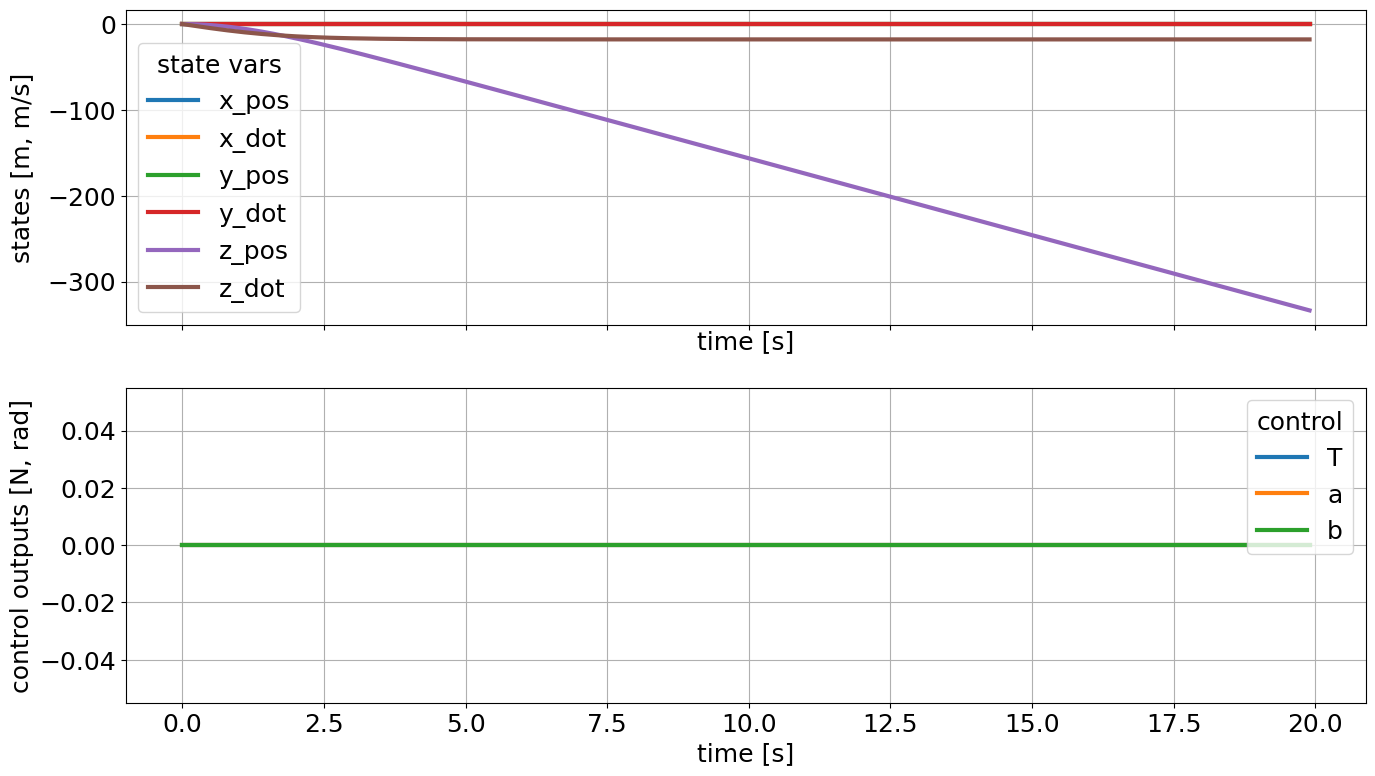

In [178]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()

# add info to the plot
state_labels = ['x_pos', 'x_dot',
                'y_pos', 'y_dot',
                'z_pos', 'z_dot']

lines = sim_graphics.result_lines['_x', 'x']   # six handles
ax[0].legend(lines, state_labels, title='state vars')

# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'T']+sim_graphics.result_lines['_u', 'a']+sim_graphics.result_lines['_u', 'b']
ax[1].legend(lines,['T', 'a', 'b'],title='control')

# Show the figure:
fig

# simulator.reset_history()
# simulator.x0 = x0
# mpc.reset_history()

In [179]:
# Once verified, we can run the actual control loop.

simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()


In [180]:
%%capture
for i in range(200):
    print('step', i)
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

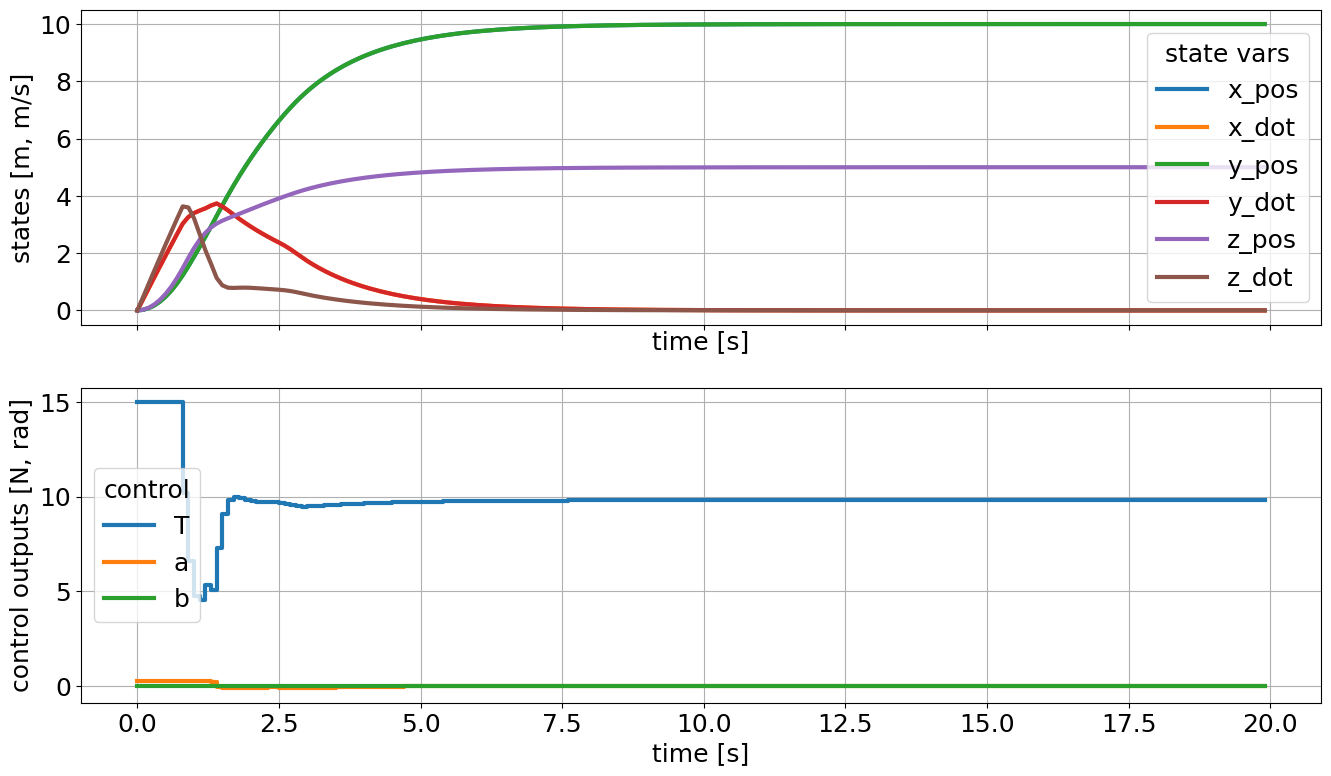

In [181]:
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()

# add info to the plot
state_labels = ['x_pos', 'x_dot',
                'y_pos', 'y_dot',
                'z_pos', 'z_dot']

lines = sim_graphics.result_lines['_x', 'x']   # six handles
ax[0].legend(lines, state_labels, title='state vars')

# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'T']+sim_graphics.result_lines['_u', 'a']+sim_graphics.result_lines['_u', 'b']
ax[1].legend(lines,['T', 'a', 'b'],title='control')

fig